In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

from objectes import Indicators

df = pd.read_csv("XAUUSD_M30.csv")
df = df[-500:]
df.index = [i for i in range(len(df))]
indicator = Indicators(df["open"], df["low"], df["high"], df["close"])

df["RSI"] = indicator.RSI(periods=14, ema=True)

# Create Up vs Down in RSI Indicator 
df["up"] = np.NaN
df["down"] = np.NaN
for i in range(len(df)): 
    if df["RSI"].iloc[i]>73 and df["RSI"].iloc[i]>df["RSI"].iloc[i+1] and df["RSI"].iloc[i]>df["RSI"].iloc[i-1] and df["RSI"].iloc[i]>df["RSI"].iloc[i-2] and df["RSI"].iloc[i]>df["RSI"].iloc[i-3]:
        df["up"].iloc[i] = df["RSI"].iloc[i]
    elif df["RSI"].iloc[i]<30 and df["RSI"].iloc[i]<df["RSI"].iloc[i+1] and df["RSI"].iloc[i]<df["RSI"].iloc[i-1] and df["RSI"].iloc[i]<df["RSI"].iloc[i-2] and df["RSI"].iloc[i]<df["RSI"].iloc[i-3]:
        df["down"].iloc[i] = df["RSI"].iloc[i]

df.tail()


/tmp/ipykernel_9611/2639469421.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["down"].iloc[i] = df["RSI"].iloc[i]
/tmp/ipykernel_9611/2639469421.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["up"].iloc[i] = df["RSI"].iloc[i]


,time,open,high,low,close,vol,RSI,up,down
495,2022-09-09 15:00,1715.244,1715.584,1714.498,1715.558,30,42.899697,NaN,NaN
496,2022-09-09 15:30,1715.508,1716.268,1714.888,1714.958,30,41.554030,NaN,NaN
497,2022-09-09 16:00,1714.988,1716.183,1714.538,1715.538,30,43.402210,NaN,NaN
498,2022-09-09 16:30,1715.538,1716.094,1715.244,1715.878,30,44.509956,NaN,NaN
499,2022-09-09 17:00,1715.878,1717.814,1715.714,1715.938,30,44.715593,NaN,NaN


In [16]:
# Split Up vs Down in RSI Indicator       
get_d = []
for i, val in enumerate(df["down"].notnull()):
    if val:
        get_d.append(i)

get_u = []
for i, val in enumerate(df["up"].notnull()):
    if val:
        get_u.append(i)


# Get all subsets from lists
sub_d = list(combinations(get_d, 2))
sub_u = list(combinations(get_u, 2))

In [17]:
# Show examples
sub_u

[(77, 262), (77, 321), (77, 472), (262, 321), (262, 472), (321, 472)]

In [18]:
# Get splops and epsilon to remove noises 
def lines_slops(main_df, point):
    lineـslope = (main_df["RSI"].iloc[point[1]] - main_df["RSI"].iloc[point[0]]) / (point[1] - point[0])
    epsilon = point[1] - point[0]
    return lineـslope, epsilon

for i in sub_u:
    print(lines_slops(df, i))
    

(0.05057209778263665, 185)
(0.016511353305535846, 244)
(0.007894418993853767, 395)
(-0.09028928615655991, 59)
(-0.029702583748645445, 210)
(-0.006029633801182173, 151)


In [21]:
# Use lines function that create before
EPSILON_DECAY = 20
SLOPES_DECAY = 0.008
df['Buy'] = np.NaN
df['Sell'] = np.NaN
for i in sub_d:
    slopes, epsilon = lines_slops(df, i)
    if slopes>SLOPES_DECAY and epsilon>EPSILON_DECAY:
        if df['RSI'].iloc[i[0]]>df['RSI'].iloc[i[1]] and df['close'].iloc[i[0]]<df['close'].iloc[i[1]]:
            df['Buy'].iloc[i[1]] = df['close'].iloc[i[1]]

for i in sub_u:
    slopes, epsilon = lines_slops(df, i)
    if slopes>SLOPES_DECAY and epsilon>EPSILON_DECAY:
        if df['RSI'].iloc[i[0]]<df['RSI'].iloc[i[1]] and df['close'].iloc[i[0]]>df['close'].iloc[i[1]]:
            df['Sell'].iloc[i[1]] = df['close'].iloc[i[1]]
        

/tmp/ipykernel_9611/3762969436.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sell'].iloc[i[1]] = df['close'].iloc[i[1]]


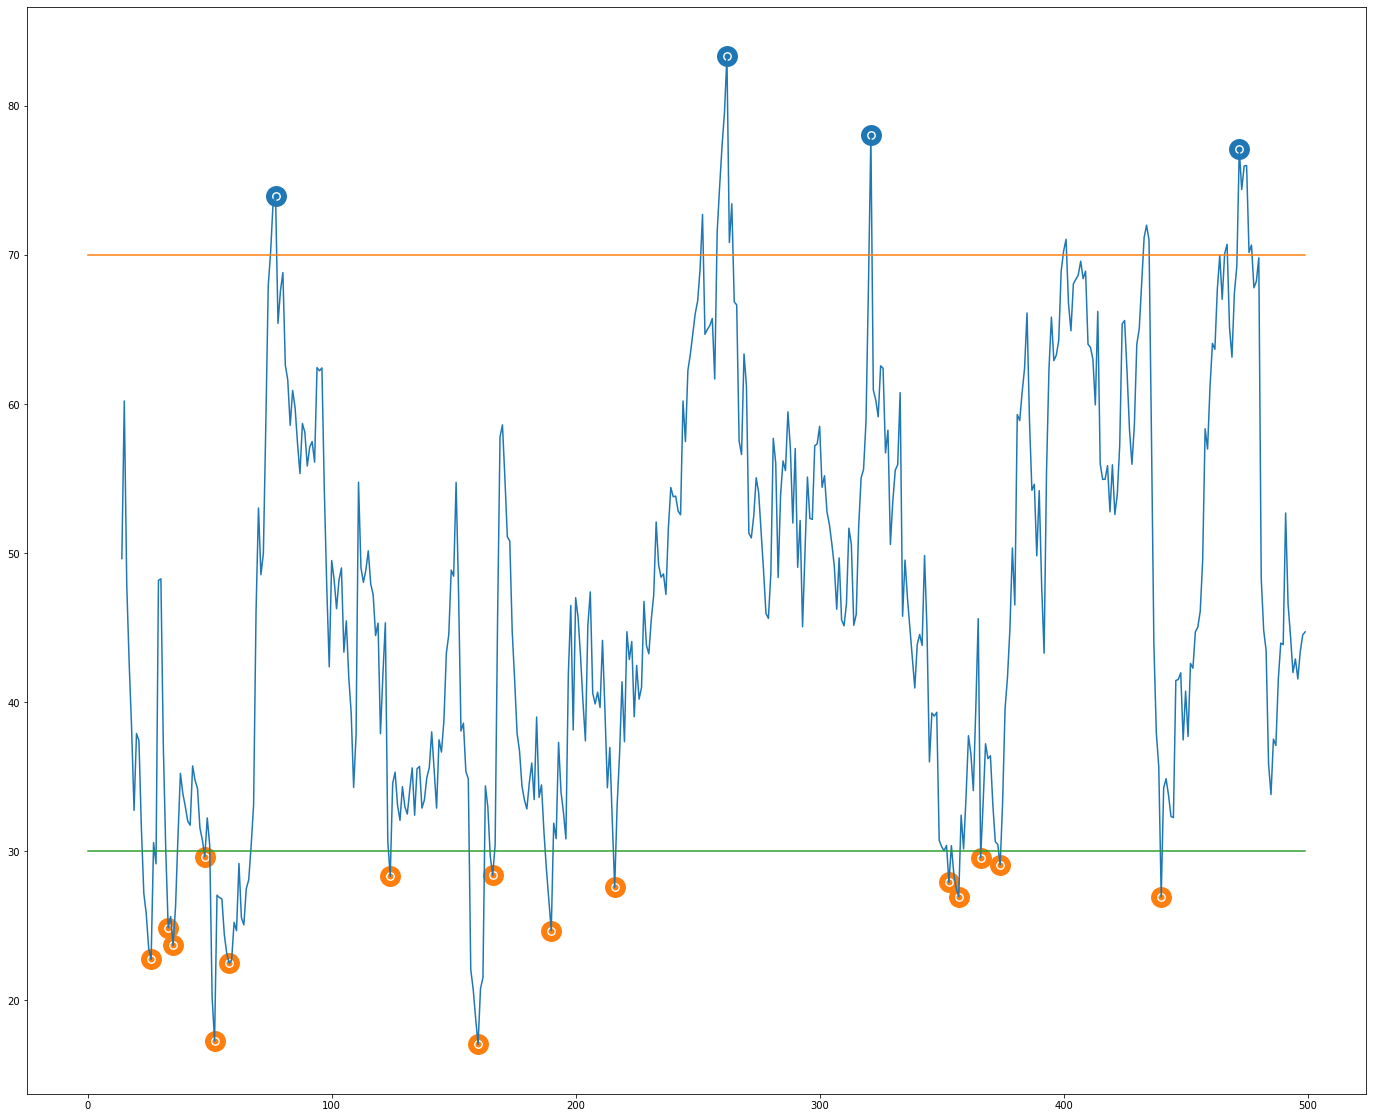

In [22]:
plt.figure(figsize=(24, 20))  
u = [70 for i in range(len(df))]
d = [30 for i in range(len(df))]
plt.plot(df.index, df.RSI)
plt.plot(u)
plt.plot(d)
plt.scatter(df.index, df["up"],linewidths=15)
plt.scatter(df.index, df["down"],linewidths=15)
plt.show()

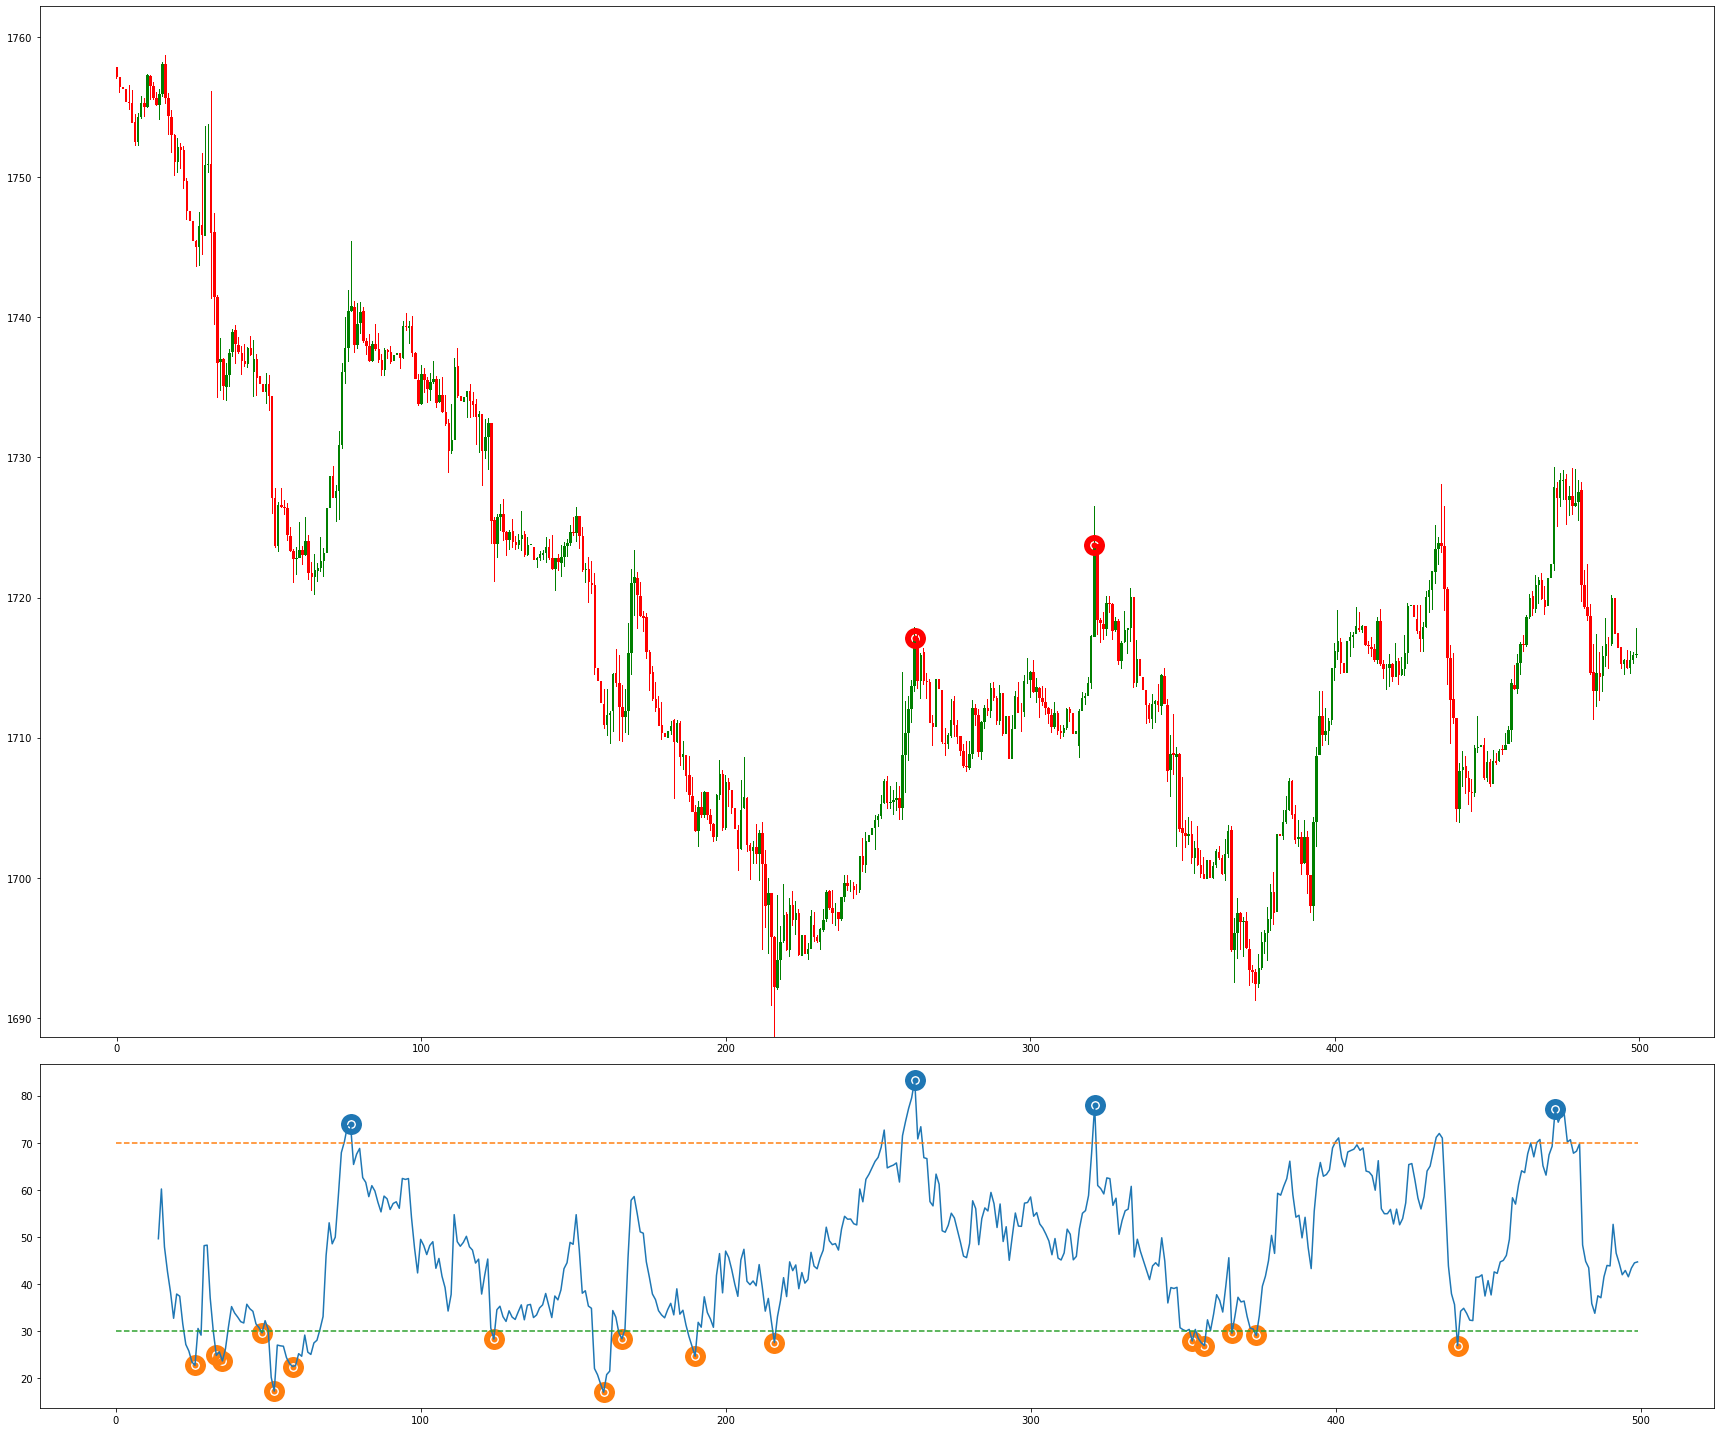

<Figure size 1728x1440 with 0 Axes>

In [23]:
        
fig, (ax, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(24, 20))
def chandlesPlot(d, o, h, l, c):
    color = []
    for open_p, close_p in zip(o, c):
        if open_p<close_p:
            color.append("g")
        else:
            color.append("r")

    ax.bar(d, height=np.abs(o-c), 
            width=0.8, 
            color=color, 
            bottom=np.min((o, c), axis=0))
    ax.bar(d, height=h-l, width=0.3, color=color, bottom=l)
    
    
chandlesPlot(df.index, df["open"], 
             df["high"], df["low"], 
             df["close"])



ax.scatter(df.index, df["Buy"] , color="g", linewidths=15, label="Buy")
ax.scatter(df.index, df["Sell"] , color="r", linewidths=15, label="Sell")
plt.figure(figsize=(24, 20))
u = [70 for i in range(len(df))]
d = [30 for i in range(len(df))]
ax1.plot(df.index, df.RSI)
ax1.plot(u, linestyle='--')
ax1.plot(d, linestyle='--')
ax1.scatter(df.index, df["up"],linewidths=15)
ax1.scatter(df.index, df["down"],linewidths=15)
fig.tight_layout()
plt.show()